In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime,date,timedelta,timezone
import pytz

import yfinance as yf

from ta.utils import dropna
import ta.trend as ta_trend
import ta.momentum as ta_mmt
import ta.others as ta_other
import ta 

# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import seaborn as sns

#SELECT * FROM `pongthorn.FinAssetForecast.fin_data`  where Date >= '2023-05-25' order by Date

from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.exceptions import NotFound
from google.api_core.exceptions import BadRequest

# Often when people are talking about the stock market, 
# they're referring to US exchanges – such as the NYSE or NASDAQ – which are open from 14.30 to 21:00 (UTC)

In [2]:
# import functions_framework
# @functions_framework.http
# def load_asset_price_yahoo(request):

# Enviroment Variable 

In [3]:
start_date=os.environ.get('START_DATE', '')  # First recoud 
end_date=os.environ.get('END_DATE', '') 

# start_date=os.environ.get('START_DATE', '2022-12-01')
# end_date=os.environ.get('END_DATE', '2023-05-31') 

#symbol_str_list="SPY,QQQ,ACWI"
symbol_str_list=os.environ.get('SYMBOL_STR_LIST', 'SPY') 
nLastToIndy=int(os.environ.get('N_LAST_DATA', '45'))  # default=45


# Constant Value

In [4]:
source='csv'  # csv / yahoo
my_tz='Asia/Bangkok'
#write_method='WRITE_EMPTY' #'WRITE_TRUNCATE'
write_method='WRITE_APPEND'

In [5]:
symbol_list= symbol_str_list.split(',')

import_dt=datetime.now(timezone.utc)
#import_dt=datetime.now(pytz.timezone(my_tz))
#import_dt=datetime.now(pytz.utc)

if  start_date=='' and end_date=='':
  start_date=(import_dt+timedelta(days=-1)).strftime("%Y-%m-%d")
  end_date= import_dt.strftime("%Y-%m-%d")
  # end_date=start_date  
    
print(f"Get {symbol_list} from {start_date} to {end_date} at {import_dt}" ) 

Get ['SPY'] from 2023-06-01 to 2023-06-02 at 2023-06-02 06:56:36.424590+00:00


In [6]:
list_cols=['Date','Symbol','Close']

# BigQuery

In [7]:
projectId="pongthorn"
dataset_id='FinAssetForecast'
table_data_id=f"{projectId}.{dataset_id}.fin_data"
print(table_data_id)

client = bigquery.Client(project=projectId )

def load_data_bq(sql:str):
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 return df


def importDataToBQ(dfToBQ):
    try:
            job_config = bigquery.LoadJobConfig(
                write_disposition=write_method,
            )
            job = client.load_table_from_dataframe(
                dfToBQ, table_data_id, job_config=job_config,
            )  # Make an API request.
            job.result()  # Wait for the job to complete.
            print(f"{source}-Total", len(dfToBQ), f" Add transaction to {table_data_id} bigquery successfully")
    except:
          print(job.error_result)

pongthorn.FinAssetForecast.fin_data


# Build Indicator as Feature using TA-Lib

In [25]:
def build_indicator_feature(df):
    #df['MA5']=ta_trend.sma_indicator(close=df['Close'],window=5,fillna=True).round(4)
    df['EMA1']=ta_trend.ema_indicator(close=df['Close'],window=10,fillna=True).round(4)
    df['EMA2']=ta_trend.ema_indicator(close=df['Close'],window=20,fillna=True).round(4)
    df['MACD']=ta_trend.macd(close=df['Close'], window_slow=20, window_fast=10, fillna=True).round(4)
    df['SIGNAL']=ta_trend.macd_signal(close=df['Close'], window_slow=20, window_fast=10,window_sign=15, fillna=True).round(4)
    return df   

# Load data from CSV (Export from Amibroker)

In [26]:
if source=='csv':
    print("Load data from CSV (Export from Amibroker)")
    '''
    Afl file on Amibroker  Explore to train TS 01-12-2014 - 31-05-2023
    Filter=1; 
    AddColumn(C,"close"); 
    '''
    ab_path="data/AB-SPY_2014-12-01-2023-05-31.csv"
    dfCSV=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
    dfCSV.columns=['Symbol','Date','Close']
    dfCSV=dfCSV[list_cols]
    dfCSV=dfCSV.drop_duplicates(subset=['Date','Symbol'],keep='last')
    dfCSV=build_indicator_feature(dfCSV)
    dfCSV['ImportDateTime']=import_dt
    # dfCSV['ImportDateTime']=dfCSV['ImportDateTime'].dt.tz_localize('utc').dt.tz_convert(my_tz)
    print(dfCSV.info())
    importDataToBQ(dfCSV)

Load data from CSV (Export from Amibroker)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138 entries, 0 to 2137
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            2138 non-null   datetime64[ns]     
 1   Symbol          2138 non-null   object             
 2   Close           2138 non-null   float64            
 3   EMA1            2138 non-null   float64            
 4   EMA2            2138 non-null   float64            
 5   MACD            2138 non-null   float64            
 6   SIGNAL          2138 non-null   float64            
 7   ImportDateTime  2138 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(5), object(1)
memory usage: 150.3+ KB
None
csv-Total 2138  Add transaction to pongthorn.FinAssetForecast.fin_data bigquery successfully


# Load data from Yahoo

In [140]:
if source=='yahoo':
    print("Load data from Yahoo")
    dfMain=pd.DataFrame(columns=list_cols)
    print(dfMain)

    for symbol in symbol_list:

        dfx=yf.download(tickers=symbol,start=start_date,end=end_date)

        if dfx.empty==False:
            print(f"=============={symbol}=============")  
            dfx.reset_index(drop=False,inplace=True)  
            dfx['Symbol']=symbol
            dfx=dfx[['Date','Symbol','Close']] 

            minDate=dfx['Date'].min().strftime("%Y-%m-%d")
            print("First Row of Yahoo"+minDate)
            sqlX=f"""
            SELECT Date,Symbol,Close FROM `{table_data_id}` 
            Where  Date between  DATE_SUB(DATE '{minDate}', INTERVAL {nLastToIndy} Day) and '{minDate}' 
            and Symbol='{symbol}' order by Date,ImportDateTime
            """
            dfHist=load_data_bq(sqlX)


            dfx=pd.concat([dfHist,dfx],axis=0,ignore_index=True)

            print(f"No {len(dfx)} past data+current to calculate TA-Indicator")
            dfx=dfx.drop_duplicates(subset=['Date','Symbol'],keep='last')
            dfx['Date']=pd.to_datetime(dfx['Date'],format='%Y-%m-%d')

            dfx=build_indicator_feature(dfx)


            print(dfx.info())            

            #dfx=dfx[dfx.Date.between(start_date, end_date)]
            dfx = dfx.query('Date >= @start_date and Date < @end_date')

            print(dfx)
            dfMain=pd.concat([dfMain,dfx])
            

        else:
          msg=f"Not found {symbol} OR No data between {start_date} and {end_date}"
          print(msg)
          #return  msg
    if dfMain.empty==False:
    
        dfMain['ImportDateTime']=import_dt
        #dfMain['ImportDateTime']=dfMain['ImportDateTime'].dt.tz_localize('utc').dt.tz_convert(my_tz)
        
        print(dfMain.info())
        proint(dfMain)
        importDataToBQ(dfMain)

Load data from Yahoo
Empty DataFrame
Columns: [Date, Symbol, Close]
Index: []
[*********************100%***********************]  1 of 1 completed
==============SPY=============
First Row of Yahoo2023-05-31
No 32 past data+current to calculate TA-Indicator
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    32 non-null     datetime64[ns]
 1   Symbol  32 non-null     object        
 2   Close   32 non-null     float64       
 3   EMA1    32 non-null     float64       
 4   EMA2    32 non-null     float64       
 5   MACD    32 non-null     float64       
 6   SIGNAL  32 non-null     float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.0+ KB
None
         Date Symbol       Close      EMA1      EMA2    MACD  SIGNAL
31 2023-05-31    SPY  417.850006  416.5469  415.1317  1.4152  0.6864
<class 'pandas.core.frame.DataF

In [106]:
# return 'OK'


SELECT * FROM `pongthorn.FinAssetForecast.fin_data` 
where (Date>='2020-01-01' and Date<='2023-06-01')
and Symbol='SPY'



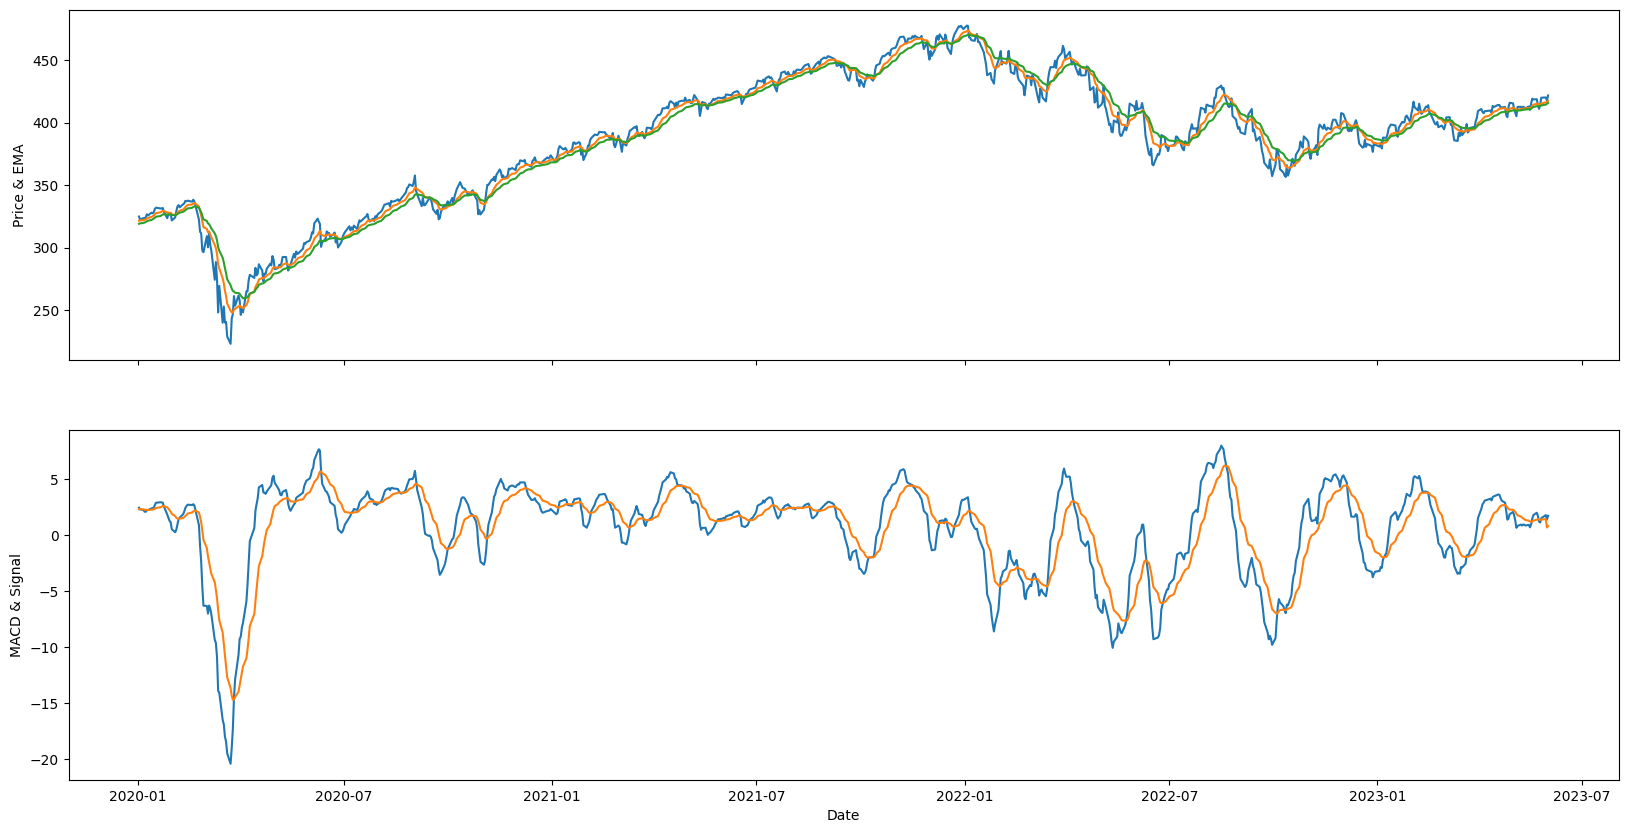

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
startPriceData='2020-01-01'
endPriceData='2023-06-01'
asset_name='SPY'

sqlData=f"""
SELECT * FROM `pongthorn.FinAssetForecast.fin_data` 
where (Date>='{startPriceData}' and Date<='{endPriceData}')
and Symbol='{asset_name}'
"""
print(sqlData)

dfData=load_data_bq(sqlData)
dfData=dfData.set_index('Date')
dfData=dfData.sort_index()

plt.subplots(2, 1, figsize = (20, 10),sharex=True)

ax1 = plt.subplot(2, 1, 1)
plt.plot(dfData.index,dfData[['Close','EMA1','EMA2']])
plt.ylabel('Price & EMA')

ax2 = plt.subplot(2, 1, 2)
plt.plot(dfData.index,dfData[['MACD','SIGNAL']])
plt.xlabel('Date')
plt.ylabel('MACD & Signal')

plt.show()